# Imports

In [188]:
# !pip install geemap && pip install opencv-python && pip install tensorflow && pip install keras && pip install rasterio && pip install scikit-image && pip install wget && pip install voila

In [189]:
import ee
import geemap
import os
import numpy as np
import matplotlib.pyplot as plt
import ee
import time
import sys
import rasterio
import wget 

from tensorflow.keras import datasets, layers, models
import argparse
import os.path
import cv2
from random import random
import csv

try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

# User inputs

In [190]:
year = 2017 # needs to be greater than 2014 
crop_type = 'rice'

# Map 

In [178]:
Map = geemap.Map(center=(14.782920, -15.274954), zoom=7)
Map

Map(center=[14.78292, -15.274954], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

In [197]:
#draw a rectangle in the above map and then run this
feature = Map.draw_last_feature
square = feature.geometry()
square.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-16.128451, 12.604339],
   [-16.128451, 12.706979],
   [-15.96923, 12.706979],
   [-15.96923, 12.604339],
   [-16.128451, 12.604339]]]}

# Functions

In [198]:
import geemap
from tqdm import tqdm
from skimage.transform import resize

targetSize = (84, 83)
def get_numpy_array_ee_image(square, collection_name):
  image_collection = IMG_COLLECTIONS[img_collection_index]
  start_date = str(year) + '-01-01'
  end_date = str(int(year)+1) + '-01-01'
  # Get ImageCollection
  imgcoll = ee.ImageCollection(image_collection) \
    .filterDate(start_date,end_date) 
  
  totalImages = imgcoll.size().getInfo()
  print("Total count of images in the collection:{} for the date range: {} - {}".format(totalImages, start_date, end_date))
  
  numpy_images = []
  for i in tqdm(range(totalImages)):
    img=ee.Image(imgcoll.toList(imgcoll.size()).get(i))
    img_numpy = geemap.ee_to_numpy(img,
                                   bands=IMG_COLLECTION_BANDS[img_collection_index], region=square, default_value=0)
    for band in range(len(IMG_COLLECTION_BANDS[img_collection_index])):
      # numpy_images.append(img_numpy[:,:,band])
      img_resized = cv2.resize(img_numpy[:,:,band],targetSize,interpolation=cv2.INTER_NEAREST)
      numpy_images.append(img_resized)
  array_numpy_images = np.array(numpy_images)
  array_numpy_images = np.transpose(array_numpy_images, (1, 2, 0))
  plt.figure(figsize=(10, 10))
  plt.suptitle("first bands in image -- total bands: {}".format(array_numpy_images.shape[-1]))
  if collection_name.lower() != 'copernicus':
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(array_numpy_images[:,:,i])
      plt.axis("off")
    plt.show()
  else:
    plt.imshow(array_numpy_images[:,:,0])
  return array_numpy_images


In [199]:
# name of GEE collections:
IMG_COLLECTIONS = ['MODIS/006/MOD09A1', 'MODIS/006/MYD11A2', 'COPERNICUS/Landcover/100m/Proba-V-C3/Global']
# Images codes -- description
IMG_COLLECTION_CODES = ['reflectance', 'temperature', 'copernicus']

# Bands that will be selected in each collection
IMG_COLLECTION_BANDS = [['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'], 
                        ['LST_Day_1km', 'LST_Night_1km'], 
                        ['discrete_classification']]


  0%|          | 0/46 [00:00<?, ?it/s]

Total count of images in the collection:46 for the date range: 2017-01-01 - 2018-01-01


100%|██████████| 46/46 [01:32<00:00,  2.01s/it]


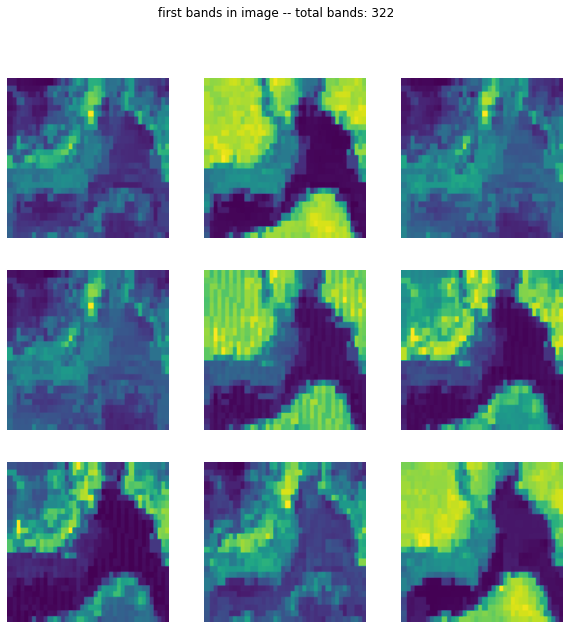


(83, 84, 322)


In [200]:
collection_name = 'reflectance'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
# TODO: not getting image from GEE and google drive ? 
reflectance_img = get_numpy_array_ee_image(square, collection_name)
print("\n{}".format(reflectance_img.shape))

  0%|          | 0/46 [00:00<?, ?it/s]

Total count of images in the collection:46 for the date range: 2017-01-01 - 2018-01-01


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]


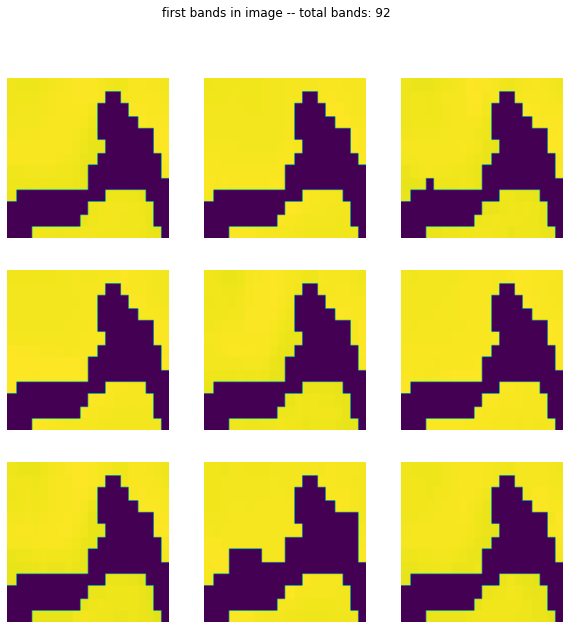


(83, 84, 92)


In [201]:
collection_name = 'temperature'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
temperature_img = get_numpy_array_ee_image(square, collection_name)
print("\n{}".format(temperature_img.shape))

  0%|          | 0/1 [00:00<?, ?it/s]

Total count of images in the collection:1 for the date range: 2017-01-01 - 2018-01-01


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


(83, 84, 1)


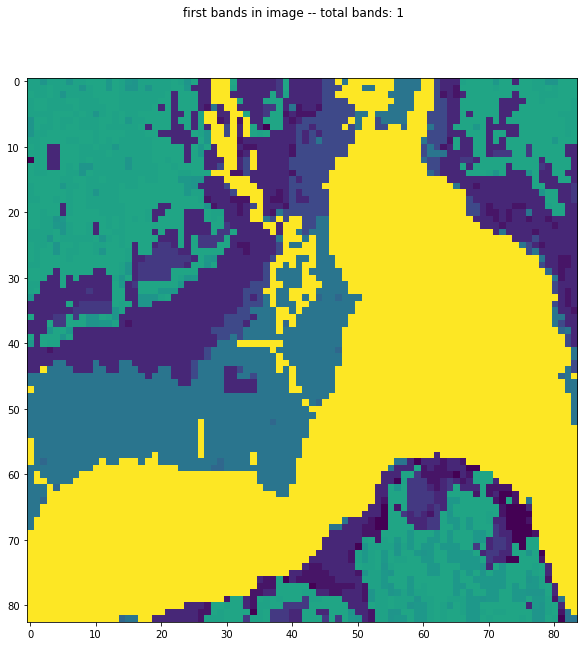

In [202]:
collection_name = 'copernicus'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
landcover_mask = get_numpy_array_ee_image(square, collection_name)
print("\n{}".format(landcover_mask.shape))
CROP_LABEL = 40 # label of cropland class 
landcover_mask = landcover_mask[:,:,0]
landcover_mask[landcover_mask != CROP_LABEL] = 0
landcover_mask[landcover_mask == CROP_LABEL] = 1

(83, 84)


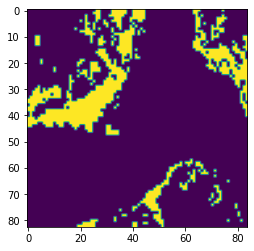

In [203]:
plt.imshow(landcover_mask)
print(landcover_mask.shape)

# Histograms

In [206]:
### Function calc_32_bins_histograms ####
# Generates 32-bins pixel counts histograms from GeoTiff
# The resulting histogram's size is [normalized bin values, number of timestamps, band]
# NB: number of timestamps N = N-day composite of GEE layers
# To be able to concanete histograms, all GeoTiff used need to have the same number of timestamps
# otherwise the sizes of the histrograms won't match
#
# Input:
# image: GeoTiff layer
# num_bands : number of bands combined in the image
# bin_seq_list: lindscape list to create the corresponding histograms
# weeks: time in weeks of the months before harvest. for 1 year: weeks = [0,46]
# for first week June to last week August: weeks = [19,30]
def calc_32_bins_histograms(image, num_bands, bin_seq_list, weeks=[0,46]):
    num_bins = 32
    num_times = image.shape[2] // num_bands
    hist = np.zeros([num_bins, num_times, num_bands])
    for i in range(image.shape[2]):
        band = i % num_bands
        density, _ = np.histogram(image[:, :, i], bin_seq_list[band], density=False)
        total = density.sum()  # normalize over only values in bins
        hist[:, i // num_bands, band] = density / float(total) if total > 0 else 0
    return hist[:, weeks[0]:weeks[1]]

#### Function mask_image
# Removes non-crop pixels in all 2D slices of 3D image tensor of shape X x Y x (bands/time)
def mask_image(img, mask, num_bands):
    num_imgs = img.shape[2]//num_bands
    assert num_imgs == int(num_imgs)
    for t in range(num_imgs):
        for b in range(num_bands):
            img[:, :, t*num_bands + b] = np.multiply(img[:, :, t*num_bands + b], mask)
    return img
def get_weeks_for_crop_type(crop_type):
  weeks = []
  if crop_type.lower() == "maize":
    weeks = [19,30] # first week of June to last week of August
  if crop_type.lower() == "millet":
    weeks = [21,30] # first week of June to last week of August
  if crop_type.lower() == "rice":
    weeks = [19,30] # first week of June to last week of August
  return weeks

def get_bin_seq_and_num_bands_for_image_collection(image_collection_name):
  print(image_collection_name)
  if image_collection_name == 'reflectance':
    bin_seq_list = [np.linspace(1, 2200, 33),
            np.linspace(900, 4999, 33),
            np.linspace(1, 1250, 33),
            np.linspace(150, 1875, 33),
            np.linspace(750, 4999, 33),
            np.linspace(300, 4999, 33),
            np.linspace(1, 4999, 33)]
    num_bands = 7
  if image_collection_name == 'temperature':
    bin_seq_list = [np.linspace(13000,16500,33), np.linspace(13000,15500,33)]
    num_bands = 2
  return bin_seq_list, num_bands

def get_histograms(image_collection_name, image_img_collection, landcover_mask):
  weeks = get_weeks_for_crop_type(crop_type)
  bin_seq, num_bands = get_bin_seq_and_num_bands_for_image_collection(image_collection_name)

  masked_image = mask_image(image_img_collection, landcover_mask, num_bands)
  print("Shape masked image: {}".format(masked_image.shape))
  hist = calc_32_bins_histograms(masked_image, num_bands, bin_seq, weeks)

  print("Shape histogram {}".format(hist.shape))
  plt.suptitle("Histograms")
  for i in range(hist.shape[-1]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hist[:, :, i])
  plt.show()
  plt.figure(1)
  plt.suptitle('Image cropped and first band histogram')
  plt.subplot(121)
  plt.imshow(masked_image[:, :, 0])
  plt.subplot(122)
  plt.imshow(hist[:, :, 0])
  return hist

reflectance
Shape masked image: (83, 84, 322)
Shape histogram (32, 11, 7)


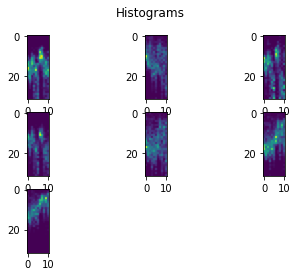

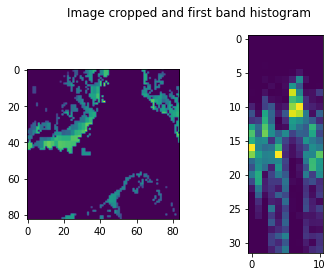

In [207]:
hist_reflectance = get_histograms('reflectance', reflectance_img, landcover_mask)

temperature
Shape masked image: (83, 84, 92)
Shape histogram (32, 11, 2)


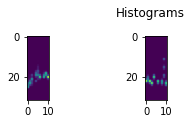

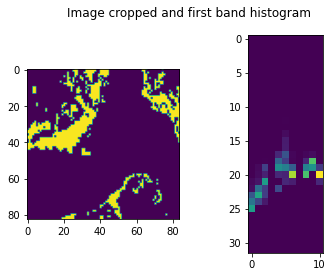

In [208]:
hist_temperature = get_histograms('temperature', temperature_img, landcover_mask)

In [209]:
hists_concat = np.concatenate((hist_reflectance, hist_temperature), axis=2)
print(hists_concat.shape)

(32, 11, 9)


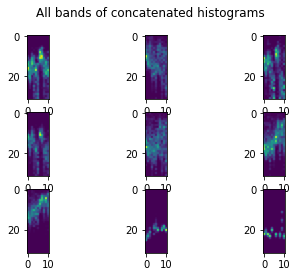

In [210]:
plt.suptitle("All bands of concatenated histograms")
for i in range(hists_concat.shape[-1]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hists_concat[:, :, i])
plt.show()

In [211]:
histogram_transposed = np.transpose(hists_concat, (1,0,2))
timestamps = []
for j in range(hists_concat.shape[1]): # going through all timestamps
  timestamps.append(np.expand_dims(histogram_transposed[j], axis=0))
print("{} timestamps of shape (1,{},{})".format(len(timestamps), timestamps[0].shape[0], timestamps[0].shape[1]))

input_shape_cnn_lstm = (11, 1, 32, 9)
print("input_shape_cnn_lstm: {} = (timestamps*1*bins*bands)".format(input_shape_cnn_lstm))
input_shape_cnn = (1, 32, 9)
print("input_shape_cnn: {} = (1*bins*bands)".format(input_shape_cnn))

11 timestamps of shape (1,1,32)
input_shape_cnn_lstm: (11, 1, 32, 9) = (timestamps*1*bins*bands)
input_shape_cnn: (1, 32, 9) = (1*bins*bands)


# Model definition and Loading weights

In [212]:
if crop_type.lower() == 'maize':
  checkpoint = "./checkpoint_maize.h5"
  wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN_LSTM/checkpoint_maize_b16_CNN-LSTM.h5", checkpoint)
if crop_type.lower() == 'millet':
  checkpoint = "./checkpoint_millet.h5"
  wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN_LSTM/checkpoint_millet_b16_CNN-LSTM.h5", checkpoint)
if crop_type.lower() == 'rice':
  checkpoint = "./checkpoint_rice.h5"
  wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN_LSTM/checkpoint_rice_b16_CNN-LSTM.h5", checkpoint)
       

In [213]:
# CNN-LSTM WIP
# https://www.mdpi.com/1424-8220/19/20/4363/htm
import tensorflow
import keras
print(tensorflow.__version__)
from keras.layers.wrappers import TimeDistributed
from keras.layers import *
from keras import regularizers
model=models.Sequential()

model.add(TimeDistributed(Conv2D(32, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001),
                                  input_shape=(input_shape_cnn)), input_shape=input_shape_cnn_lstm))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Conv2D(64, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=True, activation='relu', dropout=0.25));

model.add(TimeDistributed(Dense(64)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(1)))
model.add(GlobalAveragePooling1D(name="global_avg_flow"))

model.summary()

2.4.0
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_99 (TimeDis (None, 11, 1, 31, 32)     608       
_________________________________________________________________
time_distributed_100 (TimeDi (None, 11, 1, 31, 32)     128       
_________________________________________________________________
time_distributed_101 (TimeDi (None, 11, 1, 15, 32)     0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, 11, 1, 14, 64)     4160      
_________________________________________________________________
time_distributed_103 (TimeDi (None, 11, 1, 14, 64)     256       
_________________________________________________________________
time_distributed_104 (TimeDi (None, 11, 1, 7, 64)      0         
_________________________________________________________________
time_distributed_105 (TimeDi (None, 11, 448)   

In [214]:
model.load_weights(checkpoint)

# Predictions

predictions shape: ()
yield for rice predicted: 1.0348318815231323 T/ha for the selected region, year 2017


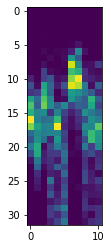

In [215]:
plt.imshow(hists_concat[:,:,0])
yield_predicted = model.predict(np.array([timestamps]))[0][0]
print("predictions shape:", yield_predicted.shape)
print("yield for {} predicted: {} T/ha for the selected region, year {}".format(crop_type,yield_predicted, year))